### The purpose of this work is to locate information from Genome-grist results to compare with fmg results
per Titus: https://mail.google.com/mail/u/0/#inbox/KtbxLzFzXsvqTmZxgnQtHTxKlZbWhGmDpg?compose=DmwnWrRpclcmkLJLppslxvvrNHbBQFTHsMgszFjGjVJPVxDggPzLTxwdzcLtrbXzsWzcgRFnRmtq

/group/ctbrowngrp4/2025-zyzhao-assemloss/85/grist/outputs/leftover/{metagenome}.summary.csv, columns:

f_covered_bp is the fraction of bases covered by at least one read. It is the equivalent to the f_match in the fmg results, representing the containment of the genome in the metagenome.
effective_coverage is the weighted and it is equivalent to the should be median_abund in the fmg results
n_mapped_reads is similar to n_unique_weighted_found (with a scaling factor) in the fmg results
summary output comparison: fmg "ref_f_weighted" is equivalent to the fraction of the n_mapped_reads divided by total number of reads.

n_mapped_reads is the sum of n_mapped_reads across each leftover/*.summary.csv file
The total number of reads is available in the file outputs/{sample}.info.yaml, produced by the genome-grist rule ‘summarize_sample_info’.

In [16]:
# Load all three inputs
import pandas as pd

# genome-grist mapped reads
mapped = pd.read_csv("mapped_reads_summary.csv")

# total reads
total = pd.read_csv("total_reads_summary.csv")

# FMG comparison results
fmg = pd.read_csv("../../fmg-db-comparison/join_rs220_k21.csv")


In [17]:
# rename sample_id to accession
mapped = mapped.rename(columns={"sample_id": "accession"})
total  = total.rename(columns={"sample_id": "accession"})

In [26]:
# Merge mapped + total reads & Compute mapped read fraction
reads = mapped.merge(total, on="accession", how="inner")
reads["grist_f_mapped_read"] = (
    reads["total_mapped_reads"] / reads["n_reads"]
)

In [27]:
# Join with FMG results
compare = (
    fmg.merge(reads, on="accession", how="inner")
       .loc[:, [
           "accession",
           "ref_f_weighted",
           "biome3",
           "grist_f_mapped_read"
       ]]
)
compare.to_csv("fmg_vs_grist_minimal.csv", index=False)
compare.head()

,accession,ref_f_weighted,biome3,grist_f_mapped_read
0,DRR014782,0.951303,Host-associated:Mammals:Respiratory system,0.905193
1,DRR014785,0.949255,Host-associated:Mammals:Respiratory system,0.904628
2,DRR121397,0.696454,Host-associated:Plants:Root,0.371231
3,DRR121401,0.650316,Host-associated:Plants:Root,0.288395
4,ERR10695318,0.889819,Engineered:Food production:Dairy products,0.859269


In [29]:
# sanity check: FMG vs genome-grist agreement (optional)
(compare["ref_f_weighted"] - compare["grist_f_mapped_read"]).abs().describe()

count    83.000000
mean      0.142164
std       0.138901
min       0.001582
25%       0.037585
50%       0.074635
75%       0.203033
max       0.461806
dtype: float64

### Compare ref_f_weighted vs grist_f_mapped_read
- Identify outliers (globally and biome-aware)
- Color-code by biome category

In [30]:
# load data
import pandas as pd
import numpy as np

df = pd.read_csv("fmg_vs_grist_minimal.csv")

# derive high-level biome class
df["biome_class"] = df["biome3"].str.split(":").str[0]

In [31]:
# Compute agreement metrics
df["delta"] = df["ref_f_weighted"] - df["grist_f_mapped_read"]
df["abs_delta"] = df["delta"].abs()

# delta > 0 → FMG reports more reference support
# delta < 0 → genome-grist maps more reads

In [32]:
# Global outliers (robust MAD method)
median = df["delta"].median()
mad = np.median(np.abs(df["delta"] - median))

df["is_outlier"] = np.abs(df["delta"] - median) > 3 * mad


In [33]:
# Biome-specific outliers
df["biome_outlier"] = False

for biome, sub in df.groupby("biome_class"):
    med = sub["delta"].median()
    mad = np.median(np.abs(sub["delta"] - med))
    idx = sub.index[np.abs(sub["delta"] - med) > 3 * mad]
    df.loc[idx, "biome_outlier"] = True


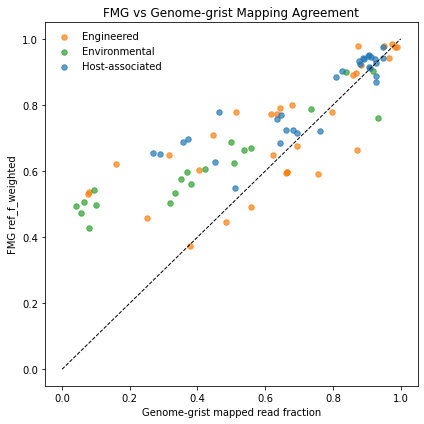

In [40]:
# Scatter plot with biome color-coding
import matplotlib.pyplot as plt

colors = {
    "Host-associated": "#1f77b4",   # blue
    "Engineered": "#ff7f0e",         # green
    "Environmental": "#2ca02c"       # orange
}

plt.figure(figsize=(6, 6))

for biome, sub in df.groupby("biome_class"):
    plt.scatter(
        sub["grist_f_mapped_read"],
        sub["ref_f_weighted"],
        label=biome,
        alpha=0.7,
        s=30,
        color=colors.get(biome, "gray")
    )

# y = x reference line
lims = [0, 1]
plt.plot(lims, lims, "k--", linewidth=1)

plt.xlabel("Genome-grist mapped read fraction")
plt.ylabel("FMG ref_f_weighted")
plt.legend(frameon=False)
plt.title("FMG vs Genome-grist Mapping Agreement")

plt.tight_layout()
plt.savefig("ref_f_weighted_vs_f_mapped_reads.png", dpi=300)
plt.show()


In [35]:
# Explicit outlier table
outliers = df[df["biome_outlier"]].sort_values("abs_delta", ascending=False)

outliers.loc[:, [
    "accession",
    "biome3",
    "ref_f_weighted",
    "grist_f_mapped_read",
    "delta"
]]

,accession,biome3,ref_f_weighted,grist_f_mapped_read,delta
25,ERR3155587,Engineered:Solid waste:Composting,0.620520,0.158714,0.461806
26,ERR3155596,Engineered:Solid waste:Composting,0.537272,0.080171,0.457101
27,ERR3155597,Engineered:Solid waste:Composting,0.530790,0.076339,0.454452
52,SRR17255031,Host-associated:Plants:Rhizosphere,0.655145,0.268876,0.386269
3,DRR121401,Host-associated:Plants:Root,0.650316,0.288395,0.361921
16,ERR2200468,Host-associated:Mammals:Digestive system,0.688371,0.355957,0.332414
5,ERR1414265,Engineered:Wastewater:Industrial wastewater,0.648253,0.317225,0.331028
2,DRR121397,Host-associated:Plants:Root,0.696454,0.371231,0.325224
60,SRR3183878,Host-associated:Human:Skin,0.777412,0.463957,0.313455
14,ERR2114805,Host-associated:Plants:Phylloplane,0.627992,0.452545,0.175447


### potential reason for outliers
- Plant root / soil-associated samples
- Low-complexity or host-contaminated metagenomes

In [36]:
# Biome-level summary
summary = (
    df.groupby("biome_class")
      .agg(
          n_samples=("accession", "count"),
          median_delta=("delta", "median"),
          mean_abs_delta=("abs_delta", "mean"),
          max_abs_delta=("abs_delta", "max")
      )
      .reset_index()
)

summary

,biome_class,n_samples,median_delta,mean_abs_delta,max_abs_delta
0,Engineered,32,0.028662,0.132028,0.461806
1,Environmental,20,0.187683,0.227699,0.452816
2,Host-associated,31,0.044628,0.097442,0.386269


### Across samples, FMG ref_f_weighted closely tracked the fraction of reads mapped by genome-grist. Agreement was strongest in host-associated and engineered biomes, while environmental and plant-associated samples showed larger deviations, consistent with increased reference incompleteness and higher community complexity.

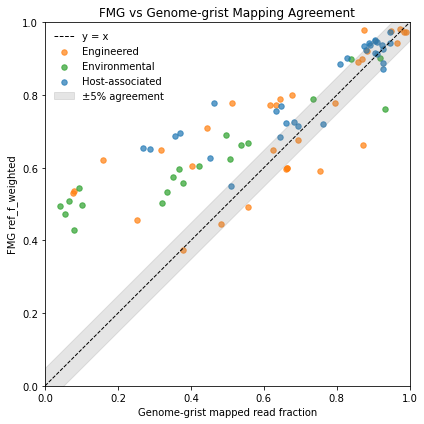

In [42]:
# add shadows
import matplotlib.pyplot as plt
import numpy as np

colors = {
    "Host-associated": "#1f77b4",
    "Engineered": "#ff7f0e",
    "Environmental": "#2ca02c"
}

plt.figure(figsize=(6, 6))

# scatter points
for biome, sub in df.groupby("biome_class"):
    plt.scatter(
        sub["grist_f_mapped_read"],
        sub["ref_f_weighted"],
        label=biome,
        alpha=0.7,
        s=30,
        color=colors.get(biome, "gray")
    )

# reference line y = x
x = np.linspace(0, 1, 200)
plt.plot(x, x, "k--", linewidth=1, label="y = x")

# ---- SHADOW BAND ----
band = 0.05   # ±5% agreement band (adjust to 0.1 if desired)

plt.fill_between(
    x,
    x - band,
    x + band,
    color="gray",
    alpha=0.2,
    label="±5% agreement"
)
# ---------------------

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xlabel("Genome-grist mapped read fraction")
plt.ylabel("FMG ref_f_weighted")
plt.title("FMG vs Genome-grist Mapping Agreement")
plt.legend(frameon=False)

plt.tight_layout()
plt.savefig("ref_f_weighted_vs_f_mapped_reads.png", dpi=300)
plt.show()